In [1]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

import torch
from torcheeg.models import EEGNet
from torcheeg.models import DGCNN
from torcheeg import transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

/home/aurelien.stumpf/Development/BCI_Classification/eeg_env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
import sys 
sys.path.append("/home/aurelien.stumpf/Development/BCI_Classification/")
from eeg_project_package import dataset, models, training

In [14]:
import importlib
importlib.reload(dataset)
importlib.reload(training)

<module 'eeg_project_package.training' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/training.py'>

## Check Loading of Physio Dataset Files

Number of channels:  64
Number of samples:  64


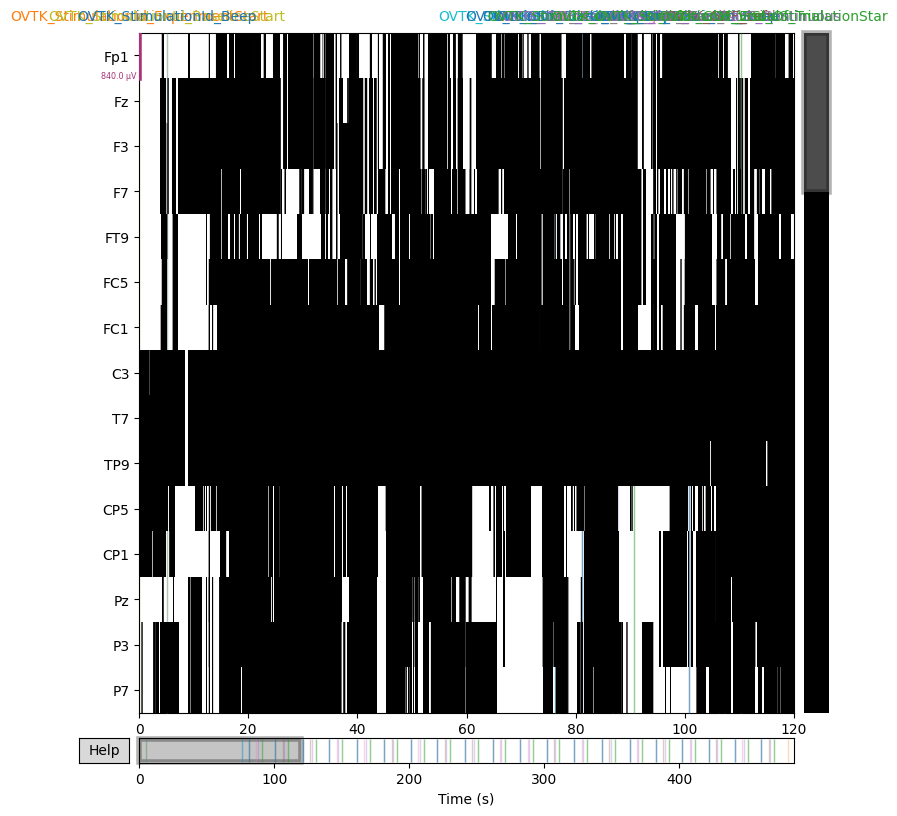

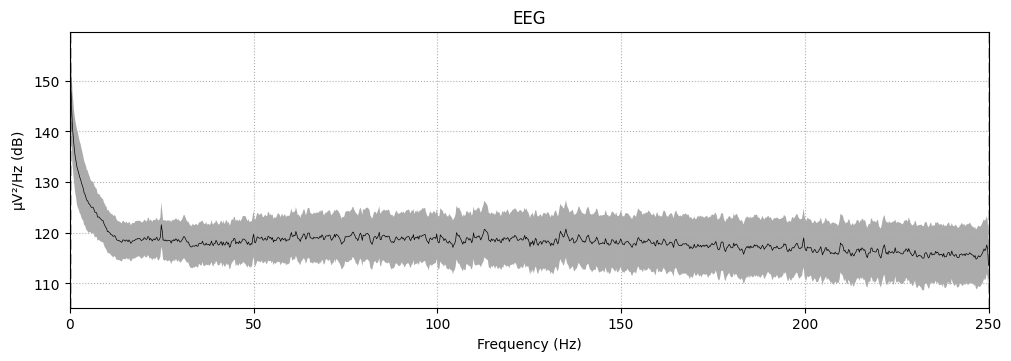

In [3]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.46.29].edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

# list of all channel names
list_all_ch_names = raw_obj.ch_names

In [4]:
dict_channels = {'Fc5.' : 'FC5',
 'Fc3.' : 'FC3',
 'Fc1.' : 'FC1',
 'Fcz.' : 'FCz',
 'Fc2.' : 'FC2',
 'Fc4.' : 'FC4',
 'Fc6.' : 'FC6',
 'C5..' : 'C5',
 'C3..' : 'C3',
 'C1..' : 'C1',
 'Cz..' : 'Cz',
 'C2..' : 'C2',
 'C4..' : 'C4',
 'C6..' : 'C6',
 'Cp5.' : 'CP5',
 'Cp3.' : 'CP3',
 'Cp1.' : 'CP1',
 'Cpz.' : 'CPz',
 'Cp2.' : 'CP2',
 'Cp4.' : 'CP4',
 'Cp6.' : 'CP6',
 'Fp1.' : 'Fp1',
 'Fpz.' : 'Fpz',
 'Fp2.' : 'Fp2',
 'Af7.' : 'AF7',
 'Af3.' : 'AF3',
 'Afz.' : 'AFz',
 'Af4.' : 'AF4',
 'Af8.' : 'AF8',
 'F7..' : 'F7',
 'F5..' : 'F5',
 'F3..' : 'F3',
 'F1..' : 'F1',
 'Fz..' : 'Fz',
 'F2..' : 'F2',
 'F4..' : 'F4',
 'F6..' : 'F6',
 'F8..' : 'F8',
 'Ft7.' : 'FT7',
 'Ft8.' : 'FT8',
 'T7..' : 'T7',
 'T8..' : 'T8',
 'T9..' : 'T9',
 'T10.' : 'T10',
 'Tp7.' : 'TP7',
 'Tp8.' : 'TP8',
 'P7..' : 'P7',
 'P5..' : 'P5',
 'P3..' : 'P3',
 'P1..' : 'P1',
 'Pz..' : 'Pz',
 'P2..' : 'P2',
 'P4..' : 'P4',
 'P6..' : 'P6',
 'P8..' : 'P8',
 'Po7.' : 'PO7',
 'Po3.' : 'PO3',
 'Poz.' : 'POz',
 'Po4.' : 'PO4',
 'Po8.' : 'PO8',
 'O1..' : 'O1',
 'Oz..' : 'Oz',
 'O2..' : 'O2',
 'Iz..' : 'Iz'}

# Make ordered dict of channels
dict_channels_ordered = dict(sorted(dict_channels.items()))


## Time Analysis

In [6]:
list_name_channels = ["Cp1.","Cp3.","Cp5.","C1..","C3..","C5..","C2..","Cp2.","Cz..","Fcz.","C4..","Cp4."]
ch_names = raw_obj.info['ch_names']
#list_idx_channels = [ch_names.index(name) for name in list_name_channels]
list_idx_channels = list(range(0, 64))

task_type = "imaginary_left/right"
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/"

if task_type == "imaginary_feet/hand":
    num_sessions = [1,2,3]
    num_train_subjects = list(range(1, 8))
    num_test_subjects = list(range(8,14))
elif task_type == "imaginary_left/right":
    num_sessions = [1,2,3]
    num_train_subjects = [1,2,3,5,6,7]   
    num_test_subjects = [8,10,11,13,14]
list_labels = ['OVTK_GDF_Left','OVTK_GDF_Right']

torch_trainset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_sessions, list_idx_channels, list_labels, feature_type="time")
torch_testset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_sessions, list_idx_channels, list_labels, feature_type="time")
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)


KeyboardInterrupt: 

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = EEGNet(chunk_size=2001,
               num_electrodes=64,
               dropout=0,
               kernel_1=64,
               kernel_2=16,
               F1=8,
               F2=16,
               D=2,
               num_classes=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
training.train_model(model, trainloader, testloader, device, criterion, 200, optimizer, scheduler)

Epoch 0:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 0: 100%|██████████| 178/178 [00:24<00:00,  7.14batch/s, accuracy=0.522, loss=0.0678]

Epoch 0
lr:  0.0095
-------------------------


Train set: Avg. loss: 0.0489, Balanced Accuracy: 0.5639045238494873 (56%)
Test set: Avg. loss: 0.0521, Balanced Accuracy: 0.5182453989982605 (52%)
-------------------------


Epoch 10: 100%|██████████| 178/178 [00:24<00:00,  7.14batch/s, accuracy=0.615, loss=0.0409]

Epoch 10
lr:  0.005688000922764597
-------------------------


Train set: Avg. loss: 0.0394, Balanced Accuracy: 0.6411516666412354 (64%)
Test set: Avg. loss: 0.0436, Balanced Accuracy: 0.561904788017273 (56%)
-------------------------


Epoch 20: 100%|██████████| 178/178 [00:24<00:00,  7.14batch/s, accuracy=0.705, loss=0.0358]

Epoch 20
lr:  0.0034056162628811476
-------------------------


Train set: Avg. loss: 0.0342, Balanced Accuracy: 0.726123571395874 (73%)
Test set: Avg. loss: 0.0464, Balanced Accuracy: 0.580703854560852 (58%)
-------------------------


Epoch 30: 100%|██████████| 178/178 [00:24<00:00,  7.15batch/s, accuracy=0.784, loss=0.0287]

Epoch 30
lr:  0.0020390682574579037
-------------------------


Train set: Avg. loss: 0.0268, Balanced Accuracy: 0.7977527976036072 (80%)
Test set: Avg. loss: 0.0539, Balanced Accuracy: 0.5895372629165649 (59%)
-------------------------


Epoch 40: 100%|██████████| 178/178 [00:24<00:00,  7.14batch/s, accuracy=0.83, loss=0.0236] 

Epoch 40
lr:  0.0012208654873684791
-------------------------


Train set: Avg. loss: 0.0217, Balanced Accuracy: 0.8444522619247437 (84%)
Test set: Avg. loss: 0.0589, Balanced Accuracy: 0.5961682796478271 (60%)
-------------------------


Epoch 50: 100%|██████████| 178/178 [00:24<00:00,  7.14batch/s, accuracy=0.864, loss=0.0194]

Epoch 50
lr:  0.0007309772651287747
-------------------------


Train set: Avg. loss: 0.0180, Balanced Accuracy: 0.879564642906189 (88%)
Test set: Avg. loss: 0.0694, Balanced Accuracy: 0.6007791757583618 (60%)
-------------------------


Epoch 60: 100%|██████████| 178/178 [00:24<00:00,  7.13batch/s, accuracy=0.89, loss=0.0164]  

Epoch 60
lr:  0.0004376630903760434
-------------------------


Train set: Avg. loss: 0.0158, Balanced Accuracy: 0.8985252976417542 (90%)
Test set: Avg. loss: 0.0810, Balanced Accuracy: 0.5953852534294128 (60%)
-------------------------


Epoch 62:  43%|████▎     | 77/178 [00:11<00:14,  6.90batch/s, accuracy=0.881, loss=0.00734] 


KeyboardInterrupt: 

In [118]:
def get_positions_from_channel_list(channel_list, montage):
    dict_positions = montage.get_positions()["ch_pos"]
    positions = []
    for channel in channel_list:
        positions.append(dict_positions[dict_channels[channel]])
    return positions

In [119]:
montage = mne.channels.make_standard_montage('standard_1020')

def get_positions_from_channel_list(channel_list, montage):
    dict_positions = montage.get_positions()["ch_pos"]
    positions = []
    for channel in channel_list:
        positions.append(dict_positions[channel])
    return positions

ch_positions = np.array(get_positions_from_channel_list(list_all_ch_names, montage))

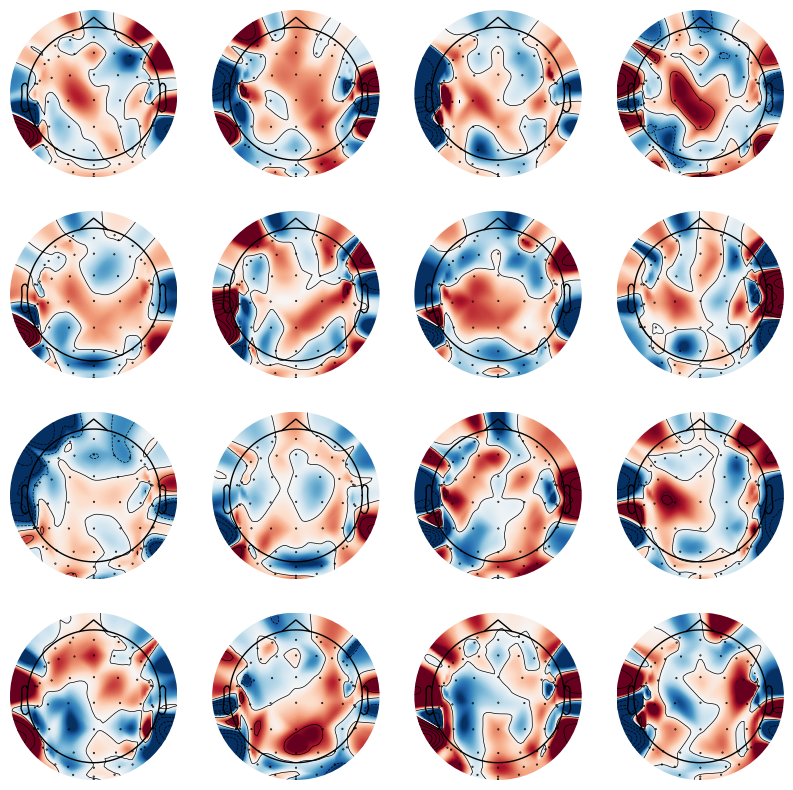

In [120]:
# display head topomap of all spatial filters 
fig, ax = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        mne.viz.plot_topomap(
            model.block1[2].weight.data[i + 4 * j].cpu().numpy().flatten(),
            ch_positions[:, :2],
            show=False,
            axes=ax[i, j]
        )

plt.show()
        

## PSD Dataset

In [123]:
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]

trainset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_sessions, list_idx_channels, list_labels, feature_type="psd")
testset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_sessions, list_idx_channels, list_labels, feature_type="psd")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)

(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-01/EEG/Test-[2022.03.15-16.39.19].edf
could not convert string to float: './.).(-*'
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 2001)
(10, 64, 200

In [124]:
X_train = trainset.features.reshape(trainset.features.shape[0], -1)
y_train = trainset.labels
X_test = testset.features.reshape(testset.features.shape[0], -1)
y_test = testset.labels

# Train LDA classifier
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("LDA Accuracy: ", acc)

# Train SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("SVM Accuracy: ", acc)

# Train XGBoost classifier
bst = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.0005, objective='binary:logistic')
bst.fit(X_train, y_train)
preds = bst.predict(X_test)
acc = np.mean(preds == y_test)
print("XGBoost Accuracy: ", acc)

LDA Accuracy:  0.544732441471572
SVM Accuracy:  0.584866220735786
XGBoost Accuracy:  0.483695652173913


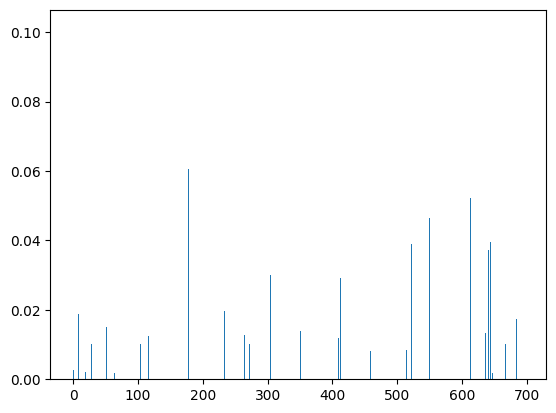

In [125]:
plt.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
plt.show()

## DGCNN

In [144]:
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]
#list_idx_channels = list(range(0, 64))

task_type = "imaginary_left/right"
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/"

if task_type == "imaginary_feet/hand":
    num_sessions = [1,2,3]
    num_train_subjects = list(range(1, 8))
    num_test_subjects = list(range(8,14))
elif task_type == "imaginary_left/right":
    num_sessions = [1,2,3]
    num_train_subjects = [1,2,3,5,6,7]   
    num_test_subjects = [8,10,11,13,14]
list_labels = ['OVTK_GDF_Left','OVTK_GDF_Right']

torch_trainset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_sessions, list_idx_channels, list_labels, feature_type="band")
torch_trainset.transform_dataset_numpy_to_torch()
torch_testset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_sessions, list_idx_channels, list_labels, feature_type="band")
torch_testset.transform_dataset_numpy_to_torch()
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Train-[2022.03.28-17.08.38].edf
(10, 12, 5)
(10, 12, 5)
/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Train-[2022.03.28-16.58.43].edf
(10, 12, 5)
(10, 12, 5)
/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-18.23.31].edf
(10, 12, 5)
(10, 12, 5)
/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.36.22].edf
(10, 12, 5)
(10, 12, 5)
/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-18.14.13].edf
(10, 12, 5)
(10, 12, 5)
/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.56.08].edf
(10, 12, 5)
(10, 12, 5)
/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.46.29].edf
(10, 12, 5)
(10, 12, 5)
/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Train-[2022.03.28-16.49.02].edf
(10, 12, 5)
(10, 12, 

In [147]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = DGCNN(in_channels=5, num_electrodes=12, hid_channels=128, num_layers=3, num_classes=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
training.train_model(model, trainloader, testloader, device, criterion, 100, optimizer, scheduler)

Epoch 0:   0%|          | 0/178 [00:00<?, ?batch/s]

Epoch 0: 100%|██████████| 178/178 [00:01<00:00, 93.39batch/s, accuracy=0.577, loss=0.044]  


Epoch 0
lr:  0.0095
-------------------------
Train set: Avg. loss: 0.0422, Balanced Accuracy: 0.5990169048309326 (60%)
Test set: Avg. loss: 0.0429, Balanced Accuracy: 0.5536938309669495 (55%)
-------------------------


Epoch 10: 100%|██████████| 178/178 [00:02<00:00, 80.30batch/s, accuracy=0.734, loss=0.0337]


Epoch 10
lr:  0.005688000922764597
-------------------------
Train set: Avg. loss: 0.0323, Balanced Accuracy: 0.740168571472168 (74%)
Test set: Avg. loss: 0.0480, Balanced Accuracy: 0.5694431066513062 (57%)
-------------------------


Epoch 20: 100%|██████████| 178/178 [00:02<00:00, 80.44batch/s, accuracy=0.779, loss=0.0293]


Epoch 20
lr:  0.0034056162628811476
-------------------------
Train set: Avg. loss: 0.0286, Balanced Accuracy: 0.7851123809814453 (79%)
Test set: Avg. loss: 0.0559, Balanced Accuracy: 0.5820709466934204 (58%)
-------------------------


Epoch 30: 100%|██████████| 178/178 [00:02<00:00, 80.52batch/s, accuracy=0.807, loss=0.0261]


Epoch 30
lr:  0.0020390682574579037
-------------------------
Train set: Avg. loss: 0.0255, Balanced Accuracy: 0.8212780952453613 (82%)
Test set: Avg. loss: 0.0500, Balanced Accuracy: 0.5994554162025452 (60%)
-------------------------


Epoch 40: 100%|██████████| 178/178 [00:02<00:00, 80.64batch/s, accuracy=0.837, loss=0.0232]


Epoch 40
lr:  0.0012208654873684791
-------------------------
Train set: Avg. loss: 0.0236, Balanced Accuracy: 0.8254915475845337 (83%)
Test set: Avg. loss: 0.0610, Balanced Accuracy: 0.5966936349868774 (60%)
-------------------------


Epoch 50: 100%|██████████| 178/178 [00:02<00:00, 78.42batch/s, accuracy=0.851, loss=0.0215]

Epoch 50
lr:  0.0007309772651287747
-------------------------


Train set: Avg. loss: 0.0211, Balanced Accuracy: 0.8542836904525757 (85%)
Test set: Avg. loss: 0.0673, Balanced Accuracy: 0.597022533416748 (60%)
-------------------------


Epoch 60: 100%|██████████| 178/178 [00:02<00:00, 78.87batch/s, accuracy=0.857, loss=0.0204]


Epoch 60
lr:  0.0004376630903760434
-------------------------
Train set: Avg. loss: 0.0199, Balanced Accuracy: 0.8658707737922668 (87%)
Test set: Avg. loss: 0.0729, Balanced Accuracy: 0.6007945537567139 (60%)
-------------------------


Epoch 63:  32%|███▏      | 57/178 [00:00<00:02, 59.52batch/s, accuracy=0.874, loss=0.00602]


KeyboardInterrupt: 

# Coherence features

In [15]:
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]

trainset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_sessions, list_idx_channels, list_labels, feature_type="coh")
testset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_sessions, list_idx_channels, list_labels, feature_type="coh")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)

/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-01/EEG/Test-[2022.03.15-16.39.19].edf
could not convert string to float: './.).(-*'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Train-[2022.04.04-16.15.17].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Train-[2022.04.04-16.14.01].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'
Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Test-[2022.04.04-16.52.15].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_GDF_Feedback_Continuous, OVTK_GDF_Right, OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep, OVTK_StimulationId_BaselineStop/OVTK_StimulationId_Beep, OVTK_GDF_Cross_On_Screen/OVTK_GDF_Start_Of_Trial/OVTK_StimulationId_Beep, OVTK_GDF_End_Of_Trial/OVTK_StimulationId_VisualStimulationStar'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.09.32].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-13/ses-01/EEG/Test-[2022.06.23-15.46.51].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-08/ses-02/EEG/Test-[2022.05.18-15.56.08].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-10/ses-02/EEG/Test-[2022.07.19-16.20.04].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-11/ses-02/EEG/Train-[2022.06.27-15.00.42].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-02/EEG/Test-[2022.04.28-16.18.42].edf
[Errno 5] Input/output error: '/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-02/EEG/Test-[2022.04.28-16.18.42].edf'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-11/ses-03/EEG/Test-[2022.07.04-16.11.03].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = event_var.get_data()
/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/dataset.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data

In [18]:
X_train = trainset.features.reshape(trainset.features.shape[0], -1)
y_train = trainset.labels
X_test = testset.features.reshape(testset.features.shape[0], -1)
y_test = testset.labels

# Train LDA classifier
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("LDA Accuracy: ", acc)

# Train SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("SVM Accuracy: ", acc)

# Train XGBoost classifier
bst = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.0005, objective='binary:logistic')
bst.fit(X_train, y_train)
preds = bst.predict(X_test)
acc = np.mean(preds == y_test)
print("XGBoost Accuracy: ", acc)

LDA Accuracy:  0.5004180602006689
SVM Accuracy:  0.504180602006689
XGBoost Accuracy:  0.5004180602006689
